# Location Intelligence Data Clustering

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
np.random.seed = 42

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

In [54]:
df = pd.read_csv('./DATA/google_places_data.csv')

# Feature Engineering

#### Deleting duplicated rows

In [55]:
df = df.drop_duplicates(subset=['business_id'])

#### Outliers

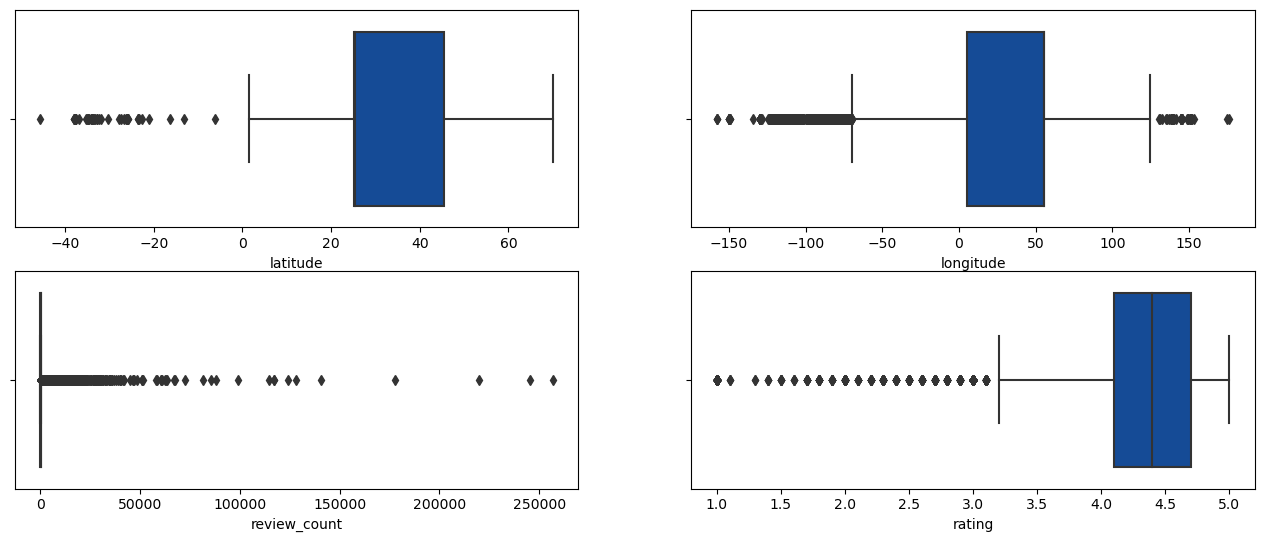

In [56]:
plt.figure(figsize = (16,13))

for i, col in enumerate(['latitude', 'longitude', 'review_count', 'rating']):
    plt.subplot(4,2,i+1)
    sns.boxplot(x = col, data = df, color='#0047AB')
plt.show()

##### Cutting off review_count

In [57]:
review_count_count = df["review_count"].value_counts().reset_index(name='count')
review_count_count = review_count_count[review_count_count['count'] > 100]
review_count_count

,review_count,count
0,32.0,2738
1,1.0,1055
2,2.0,713
3,3.0,543
4,4.0,412
5,5.0,334
6,6.0,255
7,7.0,252
8,8.0,236
9,9.0,218


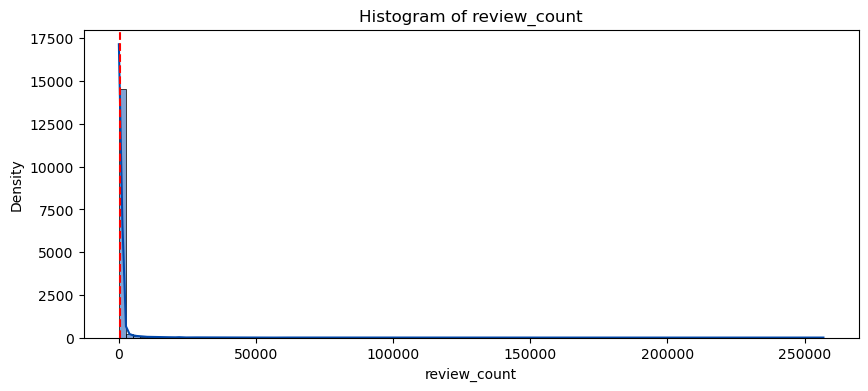

Value above which highest 10% of the data falls: 565.0


In [58]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')

highest_10_percent = df['review_count'].quantile(0.90)
plt.axvline(x=highest_10_percent, color='red', linestyle='--')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()
print("Value above which highest 10% of the data falls:", highest_10_percent)

In [59]:
df.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent

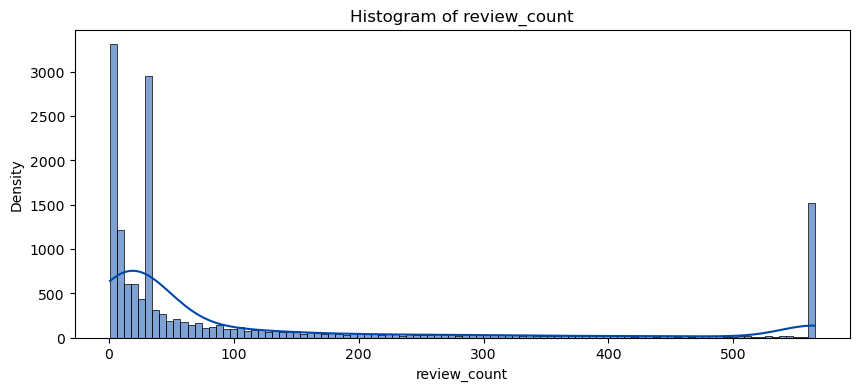

In [60]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()

### Dividing types column

In [61]:
# df_expanded = df.copy()
# df_expanded = df_expanded['types'].str.split(', ', expand=True)
# row_list = [df_expanded.iloc[i].tolist() for i in range(len(df_expanded))]
# df["type_list"] = row_list
# #X = X_train.explode('type_list', ignore_index = True)
# one_hot_encoded  = pd.get_dummies(df.explode('type_list', ignore_index = True)['type_list'])
# joined_df = df.explode('type_list', ignore_index = True).join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
# types_columns = joined_df.groupby("business_id", as_index=False).any()

# df_expanded = df.copy()
# df_expanded = df_expanded['types'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='type')
# type_counts = df_expanded['type'].value_counts().reset_index()
# type_counts.columns = ['Type', 'Count']
# type_counts = type_counts[type_counts['Count'] > 50] # można zwiększyć próg, aby było mniej kolumn
# unique_types = type_counts["Type"].unique()
# columns_to_drop = [col for col in types_columns.columns if (col not in unique_types and col not in ["business_id"])]
# types_columns = types_columns.drop(columns=columns_to_drop)

# df = pd.merge(df, types_columns, on='business_id')
# df = df.drop(columns=['type_list'])
# df.head()

#### Column removal

In [62]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
business_id,15108
phone_number,11282
name,14192
full_address,14737
latitude,14418
longitude,14422
review_count,550
rating,40
timezone,112
website,7530


In [63]:
df = df.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])

Some categorical columns have values that are mostly unique to each record in the dataset. As a result, they will not be valuable for our model and we decided to remove them. 

Removed columns: 
* business_id
* phone_number	
* name	
* full_address 
* place_id 
* place_link	

In [64]:
df = df.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening'])

From the EDA stage, we know that the columns related to business operating hours are highly correlated with each other, so we have decided to remove these columns as well.

In [65]:
df = df.drop(columns=['geo_cluster'])

We decided to remove the geo_cluster column, which resulted from a previous clustering performed on the data.

In [66]:
df = df.drop(columns=['state'])

The "state" column indicates whether a given business is open or closed at the time of data collection and how much time remains until this changes. This column is not relevant for clustering, so we have decided to remove it.

In [67]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
latitude,14418
longitude,14422
review_count,550
rating,40
timezone,112
website,7530
types,4082
Friday,761
Saturday,634
Sunday,672


##### website

In [68]:
df['has_website'] = df['website'].apply(lambda x: 0 if x == 'Unknown' else 1)

In [69]:
has_website_count = df["has_website"].value_counts().reset_index(name='count')
has_website_count

,has_website,count
0,1,8865
1,0,6243


##### country

In [70]:
def extract_country(city_country):
    if ',' in city_country:
        return city_country.split(',')[1].strip()
    if '-' in city_country:
        return city_country.split('-')[1].strip() 
    else:
        return city_country

def replace_two_letter_words(text):
    pattern = r'\b[A-Z]{2}\b'
    result = re.sub(pattern, 'USA', text)
    return result

In [71]:
df['country'] = df['country'].apply(lambda x: extract_country(x))
df['country'] = df['country'].apply(lambda x: replace_two_letter_words(x))
country_count = df["country"].value_counts().reset_index(name='count')
country_count

,country,count
0,United Arab Emirates,9521
1,USA,1708
2,Netherlands,1490
3,Germany,1127
4,United Kingdom,762
...,...,...
76,North Macedonia,1
77,Türkiye,1
78,Ghana,1
79,Latvia,1


In [72]:
category_counts = df['country'].value_counts()
rare_categories = category_counts[category_counts < 10].index
df['country'] = df['country'].apply(lambda x: 'Other' if x in rare_categories or x == 'Unknown' else x)
country_count = df["country"].value_counts().reset_index(name='count')
country_count

,country,count
0,United Arab Emirates,9521
1,USA,1708
2,Netherlands,1490
3,Germany,1127
4,United Kingdom,762
5,Other,206
6,Canada,90
7,Belgium,53
8,Russia,40
9,Australia,26


##### types

In [73]:
df['types']

0                                                   Museum
1                                                   Museum
2              National museum, Museum, Tourist attraction
3        Science museum, Heritage museum, Museum, Touri...
4              Open air museum, Museum, Tourist attraction
                               ...                        
15198                                    Van rental agency
15199                                    Car rental agency
15200                                  Car leasing service
15201                                    Car rental agency
15202                                    Car rental agency
Name: types, Length: 15108, dtype: object

In [74]:
def preprocess_text(text):
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [75]:
df['cleaned_types'] = df['types'].apply(lambda x: preprocess_text(x))
df['cleaned_types']

0                                                   museum
1                                                   museum
2                national museum museum tourist attraction
3        science museum heritage museum museum tourist ...
4                open air museum museum tourist attraction
                               ...                        
15198                                    van rental agency
15199                                    car rental agency
15200                                  car leasing service
15201                                    car rental agency
15202                                    car rental agency
Name: cleaned_types, Length: 15108, dtype: object

In [76]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned_types'])

In [25]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1
        scores.append(wcss)
    return scores

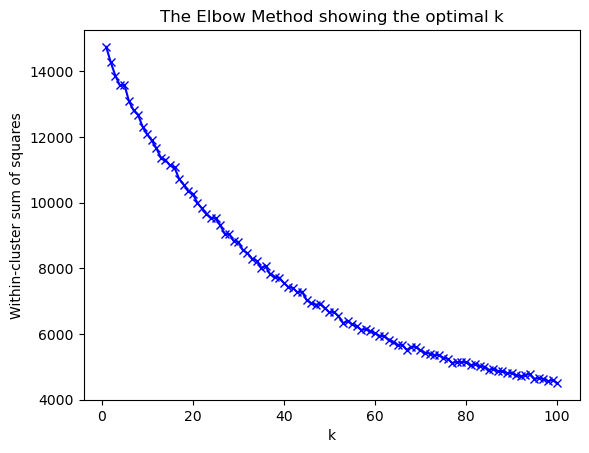

In [29]:
wcss_vec = count_wcss_scores(X, 100)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [77]:
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

In [78]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [79]:
# assign clusters and pca vectors to our dataframe 
df['cluster_type'] = clusters
df['x0'] = x0
df['x1'] = x1

In [80]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
business,office,historical,landmark,government,municipality,tourist,attraction,hall,city

Cluster 1
apartment,office,space,leasing,establishment,service,van,car,agency,rental

Cluster 2
fast,court,shop,supplier,fuel,food,store,station,convenience,gas

Cluster 3
patisserie,cake,restaurant,coffee,cafe,service,wedding,shop,establishment,bakery

Cluster 4
construction,wallpaper,contractor,plasterer,store,painting,paint,service,establishment,painter

Cluster 5
facial,waxing,removal,barber,hairdresser,spa,nail,hair,beauty,salon

Cluster 6
jeweler,hotel,locksmith,physical,therapist,university,campground,veterinarian,bar,service

Cluster 7
mobile,rv,water,campground,tourist,attraction,state,theme,amusement,park

Cluster 8
wine,goods,drug,department,supply,pet,liquor,hardware,furniture,store

Cluster 9
center,college,monument,coffee,childrens,cafe,internet,university,public,library

Cluster 10
venue,motel,spa,stay,extended,restaurant,lodging,casino,resort,hotel

Cluster 11
renter,hom

### Train, Validation and Test Sets

In [81]:
df = pd.read_csv('./DATA/google_places_data.csv')

In [82]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42)
X_train, X_val = train_test_split(X_dev, test_size=0.3, random_state=42)

### Feature engineering pipeline

In [83]:
def extract_country(city_country):
    if ',' in city_country:
        return city_country.split(',')[1].strip()
    if '-' in city_country:
        return city_country.split('-')[1].strip() 
    else:
        return city_country

def replace_two_letter_words(text):
    pattern = r'\b[A-Z]{2}\b'
    result = re.sub(pattern, 'USA', text)
    return result


def cutOffReviewCount(data):
    highest_10_percent = data['review_count'].quantile(0.90)
    data.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent
    return data

# def cutOffRating(data):
#     highest_2_percent = data['rating'].quantile(0.98)
#     data.loc[df['rating'] > highest_2_percent, 'rating'] = highest_2_percent
#     return data

def dropDuplicatedRows(data):
    data = data.drop_duplicates(subset=['business_id'])
    return data

def hasWebsite(data):
    data['has_website'] = data['website'].apply(lambda x: 0 if x == 'Unknown' else 1)
    data = data.drop(columns=['website'])
    return data

def countryColumn(data):
    data['country'] = data['country'].apply(lambda x: extract_country(x))
    data['country'] = data['country'].apply(lambda x: replace_two_letter_words(x))
    data['country'] = data['country'].apply(lambda x: 'Other' if x in rare_categories or x == 'Unknown' else x)
    return data
    

# def divingTypesColumn(data):
#     df_expanded = data.copy()
#     df_expanded = df_expanded['types'].str.split(', ', expand=True)
#     row_list = [df_expanded.iloc[i].tolist() for i in range(len(df_expanded))]
#     data["type_list"] = row_list
#     one_hot_encoded  = pd.get_dummies(data.explode('type_list', ignore_index = True)['type_list'])
#     joined_df = data.explode('type_list', ignore_index = True).join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
#     types_columns = joined_df.groupby("business_id", as_index=False).any()
    
#     df_expanded = data.copy()
#     df_expanded = df_expanded['types'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='type')
#     type_counts = df_expanded['type'].value_counts().reset_index()
#     type_counts.columns = ['Type', 'Count']
#     type_counts = type_counts[type_counts['Count'] > 50] # można zwiększyć próg, aby było mniej kolumn
#     unique_types = type_counts["Type"].unique()
#     columns_to_drop = [col for col in types_columns.columns if (col not in unique_types and col not in ["business_id"])]
#     types_columns = types_columns.drop(columns=columns_to_drop)
    
#     data = pd.merge(data, types_columns, on='business_id')
#     data = data.drop(columns=['type_list'])
#     return data

def dropUniqueColumns(data):
    data = data.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])
    return data

def dropDayTimeColumns(data):
    data = data.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening'])
    return data

def dropGeoClusterAndState(data):
    data = data.drop(columns=['geo_cluster', 'state'])
    return data


feature_engineering_pipeline = Pipeline([
    ('cutOffReviewCount', FunctionTransformer(cutOffReviewCount)),
    #('cutOffRating', FunctionTransformer(cutOffRating)),
    ('dropDuplicatedRows', FunctionTransformer(dropDuplicatedRows)),
    ('hasWebsite', FunctionTransformer(hasWebsite)),
    ('countryColumn', FunctionTransformer(countryColumn)),
    #('divingTypesColumn', FunctionTransformer(divingTypesColumn)),
    ('dropUniqueColumns', FunctionTransformer(dropUniqueColumns)),
    ('dropDayTimeColumns', FunctionTransformer(dropDayTimeColumns)),
    ('dropGeoClusterAndState', FunctionTransformer(dropGeoClusterAndState))
])

In [84]:
X_train = feature_engineering_pipeline.transform(X_train)

In [85]:
X_train

,latitude,longitude,review_count,rating,timezone,types,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,city,verified,country,has_website
7362,50.114052,8.685846,9.0,4.4,Europe/Berlin,Travel agency,10 AM-6 PM,Closed,Closed,10 AM-6 PM,10 AM-6 PM,10 AM-6 PM,10 AM-6 PM,Frankfurt,True,Germany,1
10971,25.271356,55.316515,20.0,4.7,Asia/Dubai,Mosque,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Dubai,False,United Arab Emirates,0
4882,25.312023,55.456259,35.0,4.3,Asia/Dubai,Bicycle Shop,3-11 PM,8:30 AM-11 PM,8:30 AM-11 PM,8:30 AM-11 PM,8:30 AM-11 PM,8:30 AM-11 PM,8:30 AM-11 PM,Sharjah,True,United Arab Emirates,0
10205,25.268352,55.306795,19.0,3.9,Asia/Dubai,Electronics store,4-8:30 PM,10 AM-2 PM,Closed,10 AM-2 PM,10 AM-2 PM,10 AM-2 PM,10 AM-2 PM,Dubai,True,United Arab Emirates,0
6103,25.204849,55.270783,32.0,4.4,Asia/Dubai,University,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,Dubai,False,United Arab Emirates,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,52.158834,5.382056,32.0,4.4,Europe/Amsterdam,ATM,7 AM-10 PM,7 AM-10 PM,7 AM-10 PM,7 AM-10 PM,7 AM-10 PM,7 AM-10 PM,7 AM-10 PM,Amersfoort,False,Netherlands,1
14546,38.893988,-77.036582,500.0,4.4,America/New_York,"Park, Tourist attraction",7:30 AM-4 PM,7:30 AM-4 PM,7:30 AM-4 PM,7:30 AM-4 PM,7:30 AM-4 PM,7:30 AM-4 PM,7:30 AM-4 PM,Washington,False,USA,1
15024,25.321703,55.520428,2.0,5.0,Asia/Dubai,Car rental agency,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Sharjah,True,United Arab Emirates,0
10440,25.298560,55.372075,32.0,4.4,Asia/Dubai,Restaurant,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,Sharjah,True,United Arab Emirates,0
